In [3]:
import pandas as pd

In [4]:
df=pd.read_csv(r'C:\Users\aalrassi\Documents\anastasiawork\ML_and_DS\brazil_ecom\data\brazil_ecommerce.csv')

In [5]:
df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'late_delivery', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'raw_price', 'freight_value',
       'num_items', 'payment_value', 'payment_installments', 'seller_id',
       'seller_zip_code_prefix', 'seller_city', 'seller_state', 'seller_lat',
       'seller_lng', 'customer_lat', 'customer_lng', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'product_category_name_english'],
      dtype='object')

In [ ]:
# from ydata_profiling import ProfileReport

# profile = ProfileReport(df, title="EDA Report", explorative=True)
# profile.to_file("eda_report.html")


In [ ]:
df.columns

Index(['order_status', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'late_delivery', 'customer_unique_id',
       'customer_city', 'customer_state', 'price', 'freight_value',
       'num_items', 'payment_value', 'payment_installments', 'seller_city',
       'seller_state', 'seller_lat', 'seller_lng', 'customer_lat',
       'customer_lng', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm',
       'product_category_name_english'],
      dtype='object')

In [ ]:
df[['order_delivered_carrier_date','order_delivered_customer_date']]

,order_delivered_carrier_date,order_delivered_customer_date
0,2017-10-04 19:55:00,2017-10-10 21:25:13
1,2018-07-26 14:31:00,2018-08-07 15:27:45
2,2018-08-08 13:50:00,2018-08-17 18:06:29
3,2017-11-22 13:39:59,2017-12-02 00:28:42
4,2018-02-14 19:46:34,2018-02-16 18:17:02
...,...,...
99436,2017-03-10 11:18:03,2017-03-17 15:08:01
99437,2018-02-07 23:22:42,2018-02-28 17:37:56
99438,2017-08-28 20:52:26,2017-09-21 11:24:17
99439,2018-01-12 15:35:03,2018-01-25 23:32:54


In [ ]:
df.duplicated().sum()
# Replace non-breaking spaces in a string (if pasting code as a string)

np.int64(0)

In [ ]:
import numpy as np
import pandas as pd

# --- 1. Physical distance (Haversine formula) ---
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Earth radius in km
    return c * r

df['distance_km'] = haversine(df['customer_lat'], df['customer_lng'],
                              df['seller_lat'], df['seller_lng'])

# --- 2. Order processing time ---
# Make sure timestamps are datetime
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])

df['processing_time_hours'] = (df['order_approved_at'] - df['order_purchase_timestamp']).dt.total_seconds() / 3600

# --- 3. Carrier delay potential ---
df['order_delivered_carrier_date'] = pd.to_datetime(df['order_delivered_carrier_date'])
df['carrier_delay_hours'] = (df['order_delivered_carrier_date'] - df['order_approved_at']).dt.total_seconds() / 3600

# Optional: handle missing/negative values
df['processing_time_hours'] = df['processing_time_hours'].clip(lower=0)
df['carrier_delay_hours'] = df['carrier_delay_hours'].clip(lower=0)

# Quick check
# df[['distance_km', 'processing_time_hours', 'carrier_delay_hours']].head()


In [ ]:
df = df.dropna(subset=['customer_lat', 'customer_lng', 'seller_lat', 'seller_lng',
                       'order_purchase_timestamp', 'order_approved_at',
                       'order_delivered_carrier_date'])


In [ ]:
df = df.copy()  # make a full copy first
df['baseline_pred'] = 0

# Evaluate
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

y_true = df['late_delivery']
y_pred = df['baseline_pred']

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)  # F1 for the minority class
cm = confusion_matrix(y_true, y_pred)

print(f"Baseline accuracy: {acc:.2f}")
print(f"Baseline F1-score (late deliveries): {f1:.2f}")
print("Confusion matrix:")
print(cm)


Baseline accuracy: 0.92
Baseline F1-score (late deliveries): 0.00
Confusion matrix:
[[89382     0]
 [ 7776     0]]


In [ ]:
df.columns

Index(['order_status', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'late_delivery', 'customer_unique_id',
       'customer_city', 'customer_state', 'price', 'freight_value',
       'num_items', 'payment_value', 'payment_installments', 'seller_city',
       'seller_state', 'seller_lat', 'seller_lng', 'customer_lat',
       'customer_lng', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm',
       'product_category_name_english', 'distance_km', 'processing_time_hours',
       'carrier_delay_hours', 'baseline_pred'],
      dtype='object')

In [ ]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

In [ ]:
import pandas as pd
import numpy as np

df = df.copy()  # avoid modifying original

# --- 1. Timestamp features (without leaking delivery) ---
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])
df['order_delivered_carrier_date'] = pd.to_datetime(df['order_delivered_carrier_date'])

# Time differences available at order/approval/shipping
df['time_to_approve_hours'] = (df['order_approved_at'] - df['order_purchase_timestamp']).dt.total_seconds() / 3600
df['time_to_ship_hours'] = (df['order_delivered_carrier_date'] - df['order_approved_at']).dt.total_seconds() / 3600

# Purchase day-of-week / month / hour
df['purchase_dayofweek'] = df['order_purchase_timestamp'].dt.dayofweek
df['purchase_month'] = df['order_purchase_timestamp'].dt.month
df['purchase_hour'] = df['order_purchase_timestamp'].dt.hour
df['purchase_weekend'] = df['purchase_dayofweek'].isin([5,6]).astype(int)

# --- 2. Location features ---
df['same_state'] = (df['seller_state'] == df['customer_state']).astype(int)
# distance_km already exists, optional: recompute via Haversine if needed

# --- 3. Product features ---
df['product_volume_cm3'] = df['product_length_cm'] * df['product_width_cm'] * df['product_height_cm']
df['product_density_g_per_cm3'] = df['product_weight_g'] / df['product_volume_cm3'].replace(0, np.nan)

# --- 4. Price/freight features ---
df['freight_ratio'] = df['freight_value'] / df['price'].replace(0, np.nan)

# --- 5. Customer / seller history features (aggregates) ---
# Sort by purchase time
df = df.sort_values('order_purchase_timestamp')

# Cumulative sum / count for historical rate
df['customer_orders_so_far'] = df.groupby('customer_unique_id').cumcount()
df['customer_late_cumsum'] = df.groupby('customer_unique_id')['late_delivery'].cumsum() - df['late_delivery']
df['customer_late_rate_hist'] = df['customer_late_cumsum'] / df['customer_orders_so_far'].replace(0, np.nan)
df['customer_late_rate_hist'].fillna(0, inplace=True)

# Similarly for seller
df['seller_orders_so_far'] = df.groupby('seller_city').cumcount()
df['seller_late_cumsum'] = df.groupby('seller_city')['late_delivery'].cumsum() - df['late_delivery']
df['seller_late_rate_hist'] = df['seller_late_cumsum'] / df['seller_orders_so_far'].replace(0, np.nan)
df['seller_late_rate_hist'].fillna(0, inplace=True)

# df = df.merge('customer_late_rate_hist_hist', on='customer_unique_id', how='left')
# df = df.merge('seller_late_rate_hist_hist', on='seller_city', how='left')

# --- 6. Shipment size features ---
df['total_weight'] = df['product_weight_g'] * df['num_items']
df['total_volume'] = df['product_volume_cm3'] * df['num_items']

# --- 7. Payment / order features ---
df['price_per_item'] = df['price'] / df['num_items'].replace(0, np.nan)
df['installment_value'] = df['payment_value'] / df['payment_installments'].replace(0, np.nan)

# --- 8. Interaction features ---
df['weight_times_distance'] = df['total_weight'] * df['distance_km']
df['processing_over_distance'] = df['time_to_approve_hours'] / df['distance_km'].replace(0, np.nan)

df.fillna(0, inplace=True)

import holidays

years = df['order_purchase_timestamp'].dt.year.unique()
br_holidays = holidays.Brazil(years=years)


df['is_holiday_purchase'] = df['order_purchase_timestamp'].dt.date.isin(br_holidays).astype(int)

# Now df has all engineered features that **do not leak delivery time**
features_for_model = ['is_holiday_purchase',
    'time_to_approve_hours', 'time_to_ship_hours',
    'purchase_dayofweek', 'purchase_month', 'purchase_hour', 'purchase_weekend',
    'same_state', 'distance_km',
    'product_volume_cm3', 'product_density_g_per_cm3', 'total_weight', 'total_volume',
    'freight_ratio', 'price_per_item', 'installment_value',
    'weight_times_distance', 'processing_over_distance',
    'customer_late_rate_hist', 'seller_late_rate_hist'
]

# y = df['late_delivery']


C:\Users\aalrassi\AppData\Local\Temp\ipykernel_3324\2935203292.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['customer_late_rate_hist'].fillna(0, inplace=True)
C:\Users\aalrassi\AppData\Local\Temp\ipykernel_3324\2935203292.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a cop

In [ ]:
corr = df['is_holiday_purchase'].corr(df['late_delivery'])
print(f"Correlation: {corr:.3f}")


Correlation: -0.023


### Basic training

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix

# --- 1. Select features and target ---
features = features_for_model
target = 'late_delivery'

df = df.copy()  # avoid SettingWithCopyWarning

# Drop rows with missing features
df_model = df[features + [target]].dropna()

# --- 2. Undersample majority class ---
df_late = df_model[df_model[target] == 1]
df_on_time = df_model[df_model[target] == 0]

# Randomly sample from on-time to match late deliveries
df_on_time_sampled = df_on_time.sample(n=len(df_late), random_state=42)
df_balanced = pd.concat([df_late, df_on_time_sampled]).sample(frac=1, random_state=42)  # shuffle

X = df_balanced[features]
y = df_balanced[target]

# --- 3. Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 4. Baseline prediction ---
# Option 1: Predict majority class in training set
majority_class = y_train.value_counts().idxmax()
y_pred_baseline = np.full(shape=len(y_test), fill_value=majority_class)

# --- 5. Evaluate ---
f1 = f1_score(y_test, y_pred_baseline)
f1_w = f1_score(y_test, y_pred_baseline, average='weighted')
cm = confusion_matrix(y_test, y_pred_baseline)

print("Weighted F1:", f1_w)
print(f"F1-score: {f1:.2f}")
print("Confusion matrix:")
print(cm)


Weighted F1: 0.33315477083583916
F1-score: 0.67
Confusion matrix:
[[   0 1556]
 [   0 1555]]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
import lightgbm as lgb

# --- 1. Select features and target ---
features = features_for_model
target = 'late_delivery'

df = df.copy()  # avoid SettingWithCopyWarning

# Drop rows with missing features
df_model = df[features + [target]].dropna()

# --- 2. Undersample majority class ---
df_late = df_model[df_model[target] == 1]
df_on_time = df_model[df_model[target] == 0]

# Randomly sample from on-time to match late deliveries
df_on_time_sampled = df_on_time.sample(n=len(df_late), random_state=42)
df = pd.concat([df_late, df_on_time_sampled]).sample(frac=1, random_state=42)  # shuffle

X = df[features]
y = df[target]

# --- 3. Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 4. Train LightGBM classifier ---
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_eval = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbose': -1,
    'boosting_type': 'gbdt',
    'seed': 42
}

model = lgb.train(params, lgb_train, valid_sets=[lgb_eval], num_boost_round=100)

# --- 5. Evaluate ---
y_pred = model.predict(X_test)
y_pred_binary = (y_pred >= 0.5).astype(int)

f1 = f1_score(y_test, y_pred_binary)
cm = confusion_matrix(y_test, y_pred_binary)

f1_w = f1_score(y_test, y_pred_binary, average='weighted')

print("Weighted F1:", f1_w)
print(f"F1-score: {f1:.2f}")
print("Confusion matrix:")
print(cm)


Weighted F1: 0.7076967691089057
F1-score: 0.70
Confusion matrix:
[[1132  424]
 [ 485 1070]]


Top 10 features by importance:
time_to_ship_hours          6861.677848
purchase_month              6700.212012
seller_late_rate_hist       3949.233645
distance_km                 3029.008655
processing_over_distance    1377.657679
installment_value           1271.238799
time_to_approve_hours       1210.902206
same_state                  1196.146792
price_per_item              1159.469101
weight_times_distance       1103.953690
dtype: float64


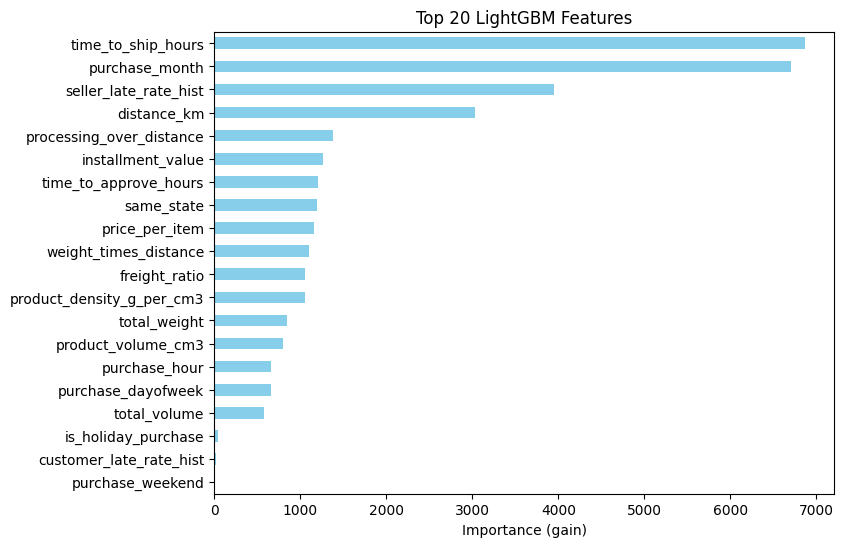

In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming you already have:
# model: trained lgb.Booster or LGBMClassifier
# X: dataframe of features used for training

# --- 1. Get feature importances ---
if isinstance(model, lgb.Booster):
    importance = model.feature_importance(importance_type='gain')  # or 'split'
else:
    importance = model.feature_importances_

feat_importances = pd.Series(importance, index=X.columns).sort_values(ascending=False)

# --- 2. Print top 10 features ---
print("Top 10 features by importance:")
print(feat_importances.head(10))

# --- 3. Visualize feature importance ---
plt.figure(figsize=(8,6))
feat_importances.head(20).plot(kind='barh', color='skyblue')
plt.xlabel("Importance (gain)")
plt.title("Top 20 LightGBM Features")
plt.gca().invert_yaxis()  # largest on top
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix

# Since balanced, baseline = predict half late, half on-time randomly
y_true = df_balanced['late_delivery'].values
y_pred = np.random.choice([0, 1], size=len(y_true))

print("F1-score:", f1_score(y_true, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))


F1-score: 0.500096618357488
Confusion matrix:
 [[3909 3867]
 [3894 3882]]


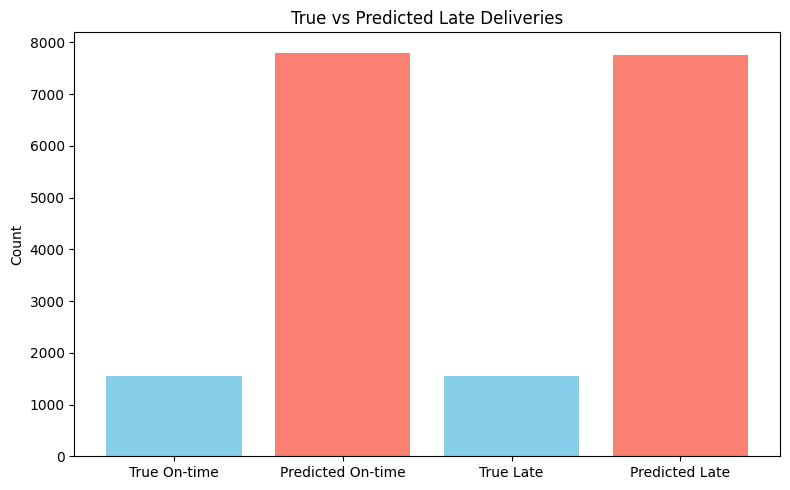

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

y_test_array = y_test.values
y_pred_binary = (y_pred >= 0.5).astype(int)


true_on_time  = np.sum(y_test_array == 0)
pred_on_time  = np.sum(y_pred_binary == 0)
true_late     = np.sum(y_test_array == 1)
pred_late     = np.sum(y_pred_binary == 1)

counts = [true_on_time, pred_on_time, true_late, pred_late]
labels = ['True On-time', 'Predicted On-time', 'True Late', 'Predicted Late']
colors = ['skyblue', 'salmon', 'skyblue', 'salmon']

fig, ax = plt.subplots(figsize=(8,5))
ax.bar(labels, counts, color=colors)
ax.set_ylabel('Count')
ax.set_title('True vs Predicted Late Deliveries')
plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred On-time', 'Pred Late'],
            yticklabels=['True On-time', 'True Late'])
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



ValueError: Found input variables with inconsistent numbers of samples: [3111, 15552]

In [ ]:
df_balanced['late_delivery'].value_counts()

late_delivery
0    7776
1    7776
Name: count, dtype: int64

In [ ]:
df[features + [target]].corr()[target].sort_values(ascending=False)

late_delivery            1.000000
carrier_delay_hours      0.212610
distance_km              0.068004
processing_time_hours    0.028635
product_weight_g         0.023055
num_items               -0.015081
Name: late_delivery, dtype: float64

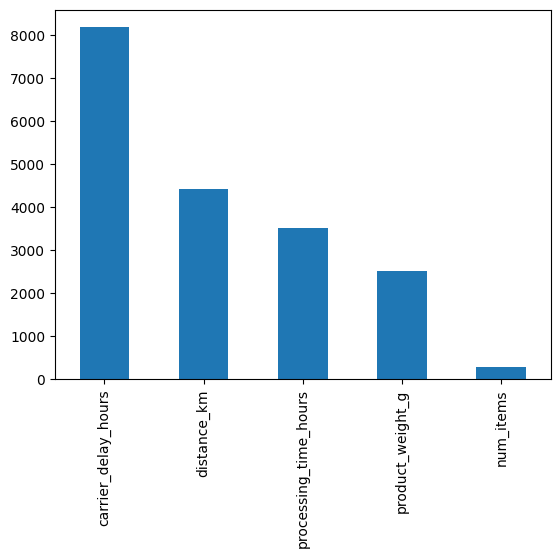

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

importance = model.feature_importance(importance_type='gain')
feat_importances = pd.Series(importance, index=features)
feat_importances.sort_values(ascending=False).plot(kind='bar')
plt.show()
